# Visualize your Google location history 
This project built upon gboeing's lovely [location-history](https://github.com/gboeing/data-visualization/tree/main/location-history) project from a few years ago.

The purpose is to compute border-crossings, as needed for annoying beurocratic things like taxes and visas. 

E.g. for my UK passport application I needed to report all my comings and goings from UK for the past 5 years.  I decided spending 10 hours messing with this was much more fun than spending 1 hour working it out by hand from emails and photos :) 

## Instructions
Click [here](https://accounts.google.com/ServiceLogin?service=backup) to download your Google location history as a JSON file called `Records.json`

It should look something like this:
```json
{
  "locations": [{
    "latitudeE7": 337625316,
    "longitudeE7": -843593197,
    "accuracy": 40,
    "source": "sensor_other",
    "timestamp": "2011-04-23T18:22:13.086Z"
  },
  ...
```

Run the relevant cells.  It should run top-to-bottom if you have all dependencies installed.

This was developed and tested on a 2021 M1 MBP with 32 GB of ram.

The main hurdle I ran into was clustering the GPS data. The example I started from used DBSCAN which always OOMed and killed my kernel.  I found some threads about fixing it, but decided to go with [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) which is a hierarchical extension of DBSCAN that I hoped was more scalable.

In my experience it still choked after about 900k datapoints, but YMMV.

In [2]:
# @title Imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from datetime import datetime as dt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

## Load GPS data from disk

In [239]:
# @title Load data
gps_filename = 'Records.json'
df_gps = pd.read_json(gps_filename)
df_gps

,locations
0,"{'latitudeE7': 337625316, 'longitudeE7': -8435..."
1,"{'latitudeE7': 337625316, 'longitudeE7': -8435..."
2,"{'latitudeE7': 337625476, 'longitudeE7': -8435..."
3,"{'latitudeE7': 337625476, 'longitudeE7': -8435..."
4,"{'latitudeE7': 337625476, 'longitudeE7': -8435..."
...,...
1512926,"{'latitudeE7': 436808047, 'longitudeE7': -7941..."
1512927,"{'latitudeE7': 436808056, 'longitudeE7': -7941..."
1512928,"{'latitudeE7': 436808065, 'longitudeE7': -7941..."
1512929,"{'latitudeE7': 436808065, 'longitudeE7': -7941..."


In [240]:
# parse lat, lon, and timestamp from the dict inside the locations column
df_gps['lat'] = df_gps['locations'].map(lambda x: x['latitudeE7'])
df_gps['lon'] = df_gps['locations'].map(lambda x: x['longitudeE7'])
df_gps['timestamp'] = df_gps['locations'].map(lambda x: x['timestamp'])

# convert lat/lon to decimalized degrees and the timestamp to date-time
df_gps['lat'] = df_gps['lat'] / 10.**7
df_gps['lon'] = df_gps['lon'] / 10.**7
df_gps['datetime'] = pd.to_datetime(df_gps['timestamp'])
date_range = df_gps['datetime'].max() - df_gps['datetime'].min()
date_range

Timedelta('4316 days 21:04:50.130000')

In [241]:
# Filter out points with altitudes above 3000 meters to remove airplane data
df_gps['altitude'] = df_gps['locations'].map(
    lambda x: x['altitude'] if 'altitude' in x else None)
mask = (df_gps['altitude'] < 3000) | (pd.isnull(df_gps['altitude']))
df_gps = df_gps[mask]


In [242]:
# Filter points exceeding a maximum velocity, indicating noisy timestamps. This
# seems to happen with timezone updates when flying.
diffs = df_gps[['lat', 'lon', 'datetime']].diff()
elapsed_time = diffs['datetime']
elapsed_seconds = elapsed_time.to_numpy() / np.timedelta64(1, 's')

dists = np.linalg.norm(diffs[['lat', 'lon']].to_numpy(), axis=1)
vels = dists / elapsed_seconds

# vels[~np.isnan(vels)].mean()
df_gps = df_gps.iloc[vels < 0.01]
df_gps

,locations,lat,lon,timestamp,datetime,altitude
1,"{'latitudeE7': 337625316, 'longitudeE7': -8435...",33.762532,-84.359320,2011-04-23T18:22:13.239Z,2011-04-23 18:22:13.239000+00:00,NaN
2,"{'latitudeE7': 337625476, 'longitudeE7': -8435...",33.762548,-84.359418,2011-04-23T18:22:37.289Z,2011-04-23 18:22:37.289000+00:00,NaN
3,"{'latitudeE7': 337625476, 'longitudeE7': -8435...",33.762548,-84.359418,2011-04-23T18:22:37.420Z,2011-04-23 18:22:37.420000+00:00,NaN
4,"{'latitudeE7': 337625476, 'longitudeE7': -8435...",33.762548,-84.359418,2011-04-23T18:24:39.204Z,2011-04-23 18:24:39.204000+00:00,NaN
5,"{'latitudeE7': 337625476, 'longitudeE7': -8435...",33.762548,-84.359418,2011-04-23T18:24:39.340Z,2011-04-23 18:24:39.340000+00:00,NaN
...,...,...,...,...,...,...
1512926,"{'latitudeE7': 436808047, 'longitudeE7': -7941...",43.680805,-79.418310,2023-02-16T14:31:49.579Z,2023-02-16 14:31:49.579000+00:00,115.0
1512927,"{'latitudeE7': 436808056, 'longitudeE7': -7941...",43.680806,-79.418319,2023-02-16T14:40:08.077Z,2023-02-16 14:40:08.077000+00:00,117.0
1512928,"{'latitudeE7': 436808065, 'longitudeE7': -7941...",43.680807,-79.418309,2023-02-16T14:41:19.550Z,2023-02-16 14:41:19.550000+00:00,114.0
1512929,"{'latitudeE7': 436808065, 'longitudeE7': -7941...",43.680807,-79.418309,2023-02-16T14:43:43.323Z,2023-02-16 14:43:43.323000+00:00,114.0


## Generate synthetic data
Run this cell instead of the cells above to experiment with the notebook without downloading your own dataset.

In [368]:
cluster_centers = np.array([
    [37.750026, -122.440632],  # San Francisco
    [-41.298983, 174.773305],  # Wellington
    [-37.797603, 145.047609],  # Melbourne
    [22.28239, 114.18182],     # Hong Kong
    [13.833773, 100.619301],   # Bangkok
    [60.409403, 110.519068],   # Siberia
    [40.195334, 44.535943],    # Kentron
    [50.053350, 19.952160],    # Krakow
    [51.501534, -0.094894],    # London
    [-1.959277, 30.077803],    # Kigali
    [-34.597327, -58.412840],  # Buenos Aires
    [-0.619014, -90.391185],   # Galapagos
    [22.070706, -79.268670],   # Cuba
    [40.780533, -73.967270],   # NYC
    [55.108008, -105.301228],  # Saskatchewan
    [34.040421, -118.260965],  # Los Angeles
])
cluster_std = np.array([
    [0.1],   # San Francisco
    [0.3],   # Wellington
    [0.3],   # Melbourne
    [0.3],   # Hong Kong
    [0.3],   # Bangkok
    [3.0],   # Siberia
    [0.05],  # Kentron
    [0.05],  # Krakow
    [0.3],   # London
    [0.05],  # Kigali
    [0.05],  # Buenos Aires
    [0.1],   # Galapagos
    [0.2],   # Cuba
    [0.2],   # NYC
    [2.0],   # Saskatchewan
    [0.2],   # Los Angeles
])

pts_per_mode = 100
pts = cluster_centers[:, None, :] + np.random.randn(cluster_centers.shape[0], pts_per_mode, 2) * cluster_std[:, None, :]
pts = pts.reshape(-1, 2)  # (num_clusters * pts_per_mode, 2)

starts = pd.date_range('2020-01-01', freq='6W', periods=cluster_centers.shape[0])
timestamps = np.hstack([pd.date_range(s, freq='1H', periods=pts_per_mode) for s in starts])

df_gps = pd.DataFrame({'timestamp': timestamps, 'lat': pts[:, 0], 'lon': pts[:, 1]})
df_gps

df_gps['datetime'] = pd.to_datetime(df_gps['timestamp'])
date_range = df_gps['datetime'].max() - df_gps['datetime'].min()
date_range

Timedelta('634 days 03:00:00')

## Map the raw dataset (approx 1.6 million points)

In [391]:
# define map colors
land_color = '#f5f5f3'
water_color = '#cdd2d4'
coastline_color = '#f5f5f3'
border_color = '#bbbbbb'
meridian_color = '#f5f5f3'
marker_fill_color = '#cc3300'
marker_edge_color = 'None'

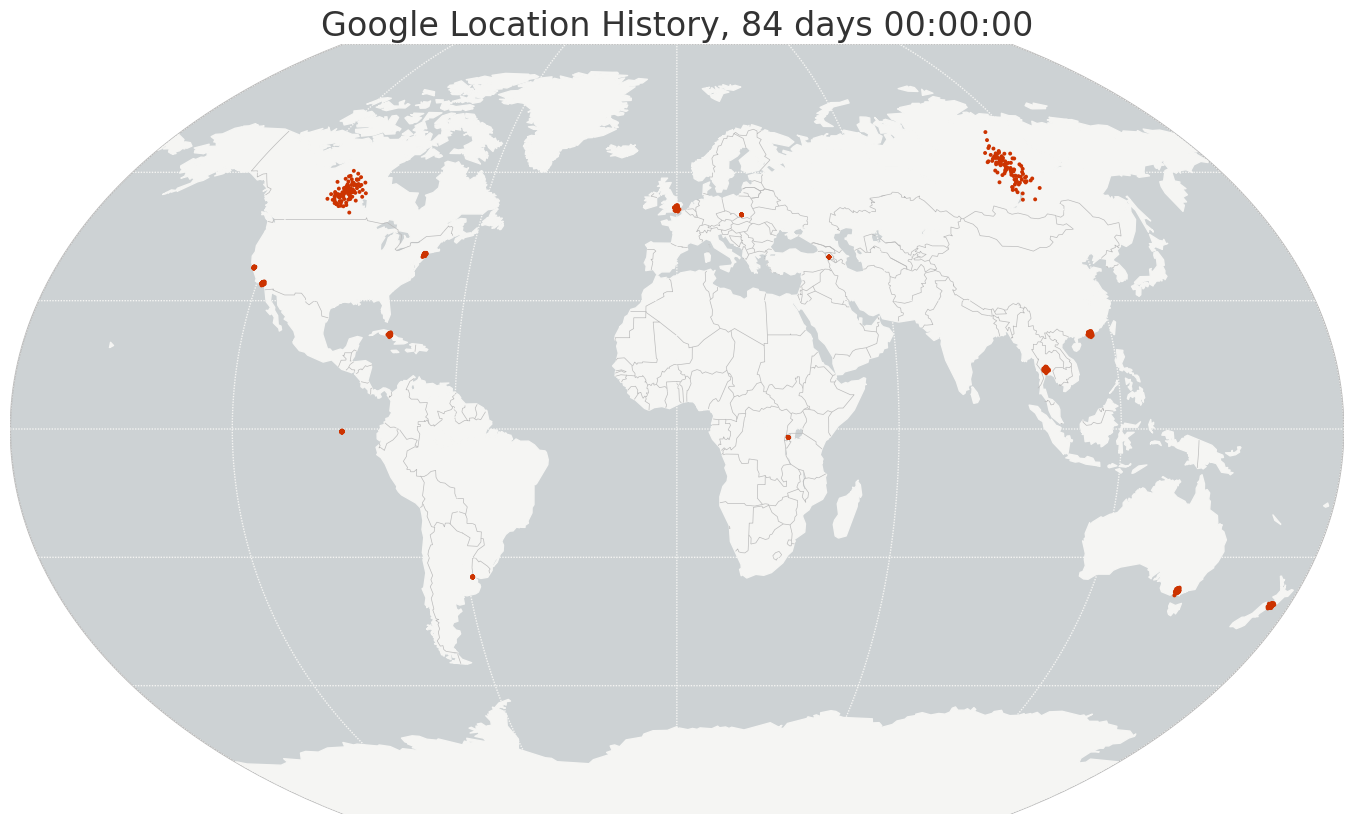

In [392]:
# create the plot
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, facecolor='#ffffff', frame_on=False)
ax.set_title('Google Location History, {}'.format(
    date_range), fontsize=24, color='#333333')

# draw the basemap and its features
m = Basemap(projection='kav7', lon_0=0, resolution='c', area_thresh=10000)
m.drawmapboundary(color=border_color, fill_color=water_color)
m.drawcoastlines(color=coastline_color)
m.drawcountries(color=border_color)
m.fillcontinents(color=land_color, lake_color=water_color)
m.drawparallels(np.arange(-90., 120., 30.), color=meridian_color)
m.drawmeridians(np.arange(0., 420., 60.), color=meridian_color)

# project the location history points then scatter plot them
x, y = m(df_gps['lon'].values, df_gps['lat'].values)
m.scatter(x, y, s=8, color=marker_fill_color,
          edgecolor=marker_edge_color, alpha=1, zorder=3)

# show the map
plt.savefig('google_location_history_world_map.png',
            dpi=96, bbox_inches='tight', pad_inches=0.2)
plt.show()


## Now map just California

In [393]:
# first define a transverse mercator projection for california
map_width_m = 1000 * 1000
map_height_m = 1200 * 1000
target_crs = {'datum':'WGS84',
              'ellps':'WGS84',
              'proj':'tmerc',
              'lon_0':-119,
              'lat_0':37.5}

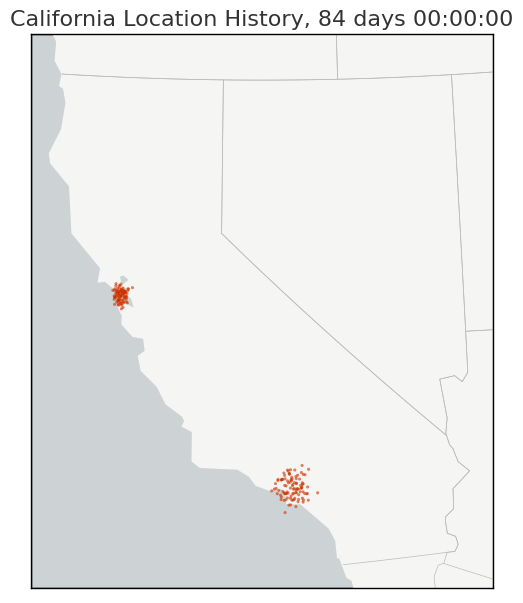

In [394]:
# plot the map
fig_width = 6
fig = plt.figure(figsize=[fig_width, fig_width *
                 map_height_m / float(map_width_m)])
ax = fig.add_subplot(111, facecolor='#ffffff', frame_on=False)
ax.set_title('California Location History, {}'.format(
    date_range), fontsize=16, color='#333333')

m = Basemap(ellps=target_crs['ellps'],
            projection=target_crs['proj'],
            lon_0=target_crs['lon_0'],
            lat_0=target_crs['lat_0'],
            width=map_width_m,
            height=map_height_m,
            resolution='l',
            area_thresh=10000)

m.drawcoastlines(color=coastline_color)
m.drawcountries(color=border_color)
m.fillcontinents(color=land_color, lake_color=water_color)
m.drawstates(color=border_color)
m.drawmapboundary(fill_color=water_color)

x, y = m(df_gps['lon'].values, df_gps['lat'].values)
m.scatter(x, y, s=5, color=marker_fill_color,
          edgecolor=marker_edge_color, alpha=0.6, zorder=3)

plt.savefig('google_location_history_cal_map.png',
            dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()


## Now map just the San Francisco Bay Area

In [395]:
# first define a transverse mercator projection centered on the bay area
map_width_m = 100 * 1000
map_height_m = 120 * 1000
target_crs = {'datum':'WGS84',
              'ellps':'WGS84',
              'proj':'tmerc',
              'lon_0':-122.3,
              'lat_0':37.8}

# define how the annotations should look
color = 'k'
weight = 'black'
size = 12
alpha = 0.3
xycoords = 'axes fraction'

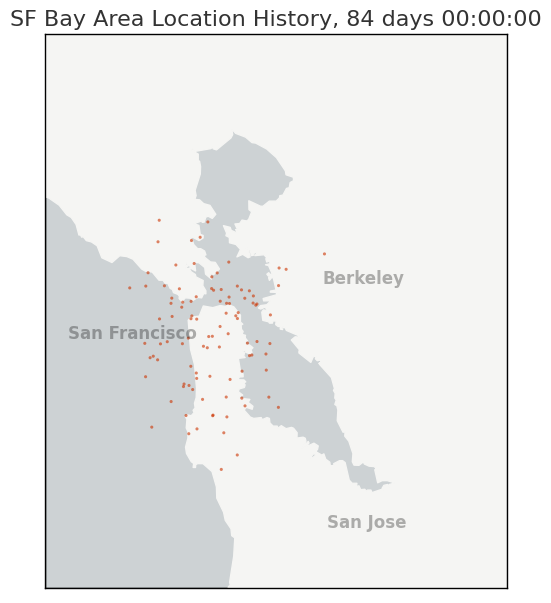

In [396]:
# plot the map
fig_width = 6
fig = plt.figure(figsize=[fig_width, fig_width * map_height_m / float(map_width_m)])
ax = fig.add_subplot(111, facecolor='#ffffff', frame_on=False)
ax.set_title('SF Bay Area Location History, {}'.format(date_range), fontsize=16, color='#333333')

m = Basemap(ellps=target_crs['ellps'],
            projection=target_crs['proj'],
            lon_0=target_crs['lon_0'], 
            lat_0=target_crs['lat_0'],
            width=map_width_m, 
            height=map_height_m,
            resolution='h',
            area_thresh=10)

m.drawcoastlines(color=coastline_color)
m.drawcountries(color=border_color)
m.fillcontinents(color=land_color, lake_color=water_color)
m.drawstates(color=border_color)
m.drawmapboundary(fill_color=water_color)
m.etopo()
x, y = m(df_gps['lon'].values, df_gps['lat'].values)
m.scatter(x, y, s=5, color=marker_fill_color, edgecolor=marker_edge_color, alpha=0.6, zorder=3)

# annotate some cities in the bay area
plt.annotate('San Francisco', xy=(0.05, 0.45), xycoords=xycoords, color=color, weight=weight, size=size, alpha=alpha)
plt.annotate('Berkeley', xy=(0.60, 0.55), xycoords=xycoords, color=color, weight=weight, size=size, alpha=alpha)
plt.annotate('San Jose', xy=(0.61, 0.11), xycoords=xycoords, color=color, weight=weight, size=size, alpha=alpha)

plt.savefig('google_location_history_sf_bay_map.png', dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

# Clustering for geo-lookup
The geopy API doesn't support batch calls, so it takes ~1s per query.
Therefore we cluster the full dataset, geo-lookup the clusters, and join the resulting country info back into the main dataframe.

## Clustering functions

In [369]:
import hdbscan
import time

import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.cluster import DBSCAN, OPTICS
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from datetime import datetime as dt

_KMS_PER_RADIAN = 6371.0088

# magic command to display matplotlib plots inline within the ipython notebook
%matplotlib inline

def get_centermost_point(cluster):
  """Find point in cluster which is closest to its geodesic centroid."""
  if cluster.shape[0] == 0:
    # Skip empty clusters, but keep them in the output so we can still index the 
    # the resulting Series using the cluster labels.
    return None
  centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
  centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
  return tuple(centermost_point)


def dbscan_reduce(
    df: pd.DataFrame,
    cluster_radius: float,
    x: str = 'lon',
    y: str = 'lat',
    min_cluster_size=10,
    min_samples=None,
):
  """Clusters the provided GPS dataframe.

  Args:
    df: A dataframe containing lat and lon in keys `x` and `y` respectively
    cluster_radius: Min distance between points defining a cluster, in km. See
      HDBSCAN `cluster_selection_epsilon`.
    x: A key for latitude column.
    y: A key for longitude column.
    min_cluster_size: A minimum number of points in a cluster.
    min_samples: A confusing param, see HDBSCAN `min_samples`.

  Returns:
    Tuple containing:
      df_clustered: A DataFrame with `num_clusters` rows containing the most
        representative point from the input dataframe.
      df_labeled: The original data frame with cluster labels added.
      db: The HDBSCAN clustering object.
  """
  
  epsilon = cluster_radius / _KMS_PER_RADIAN
  start_time = time.time()
  # Represent points consistently as (lat, lon) and convert to radians to fit
  # using haversine metric.
  coords = df[[y, x]].to_numpy()

  db = hdbscan.HDBSCAN(
    min_cluster_size=min_cluster_size,
    min_samples=min_samples,
    cluster_selection_epsilon=epsilon,
    metric='haversine',
    gen_min_span_tree=True,
    memory='/tmp/hdbscan_cache',
  ).fit(np.radians(coords),)

  cluster_labels = db.labels_
  cluster_ids = set(cluster_labels)
  num_clusters = len(cluster_ids)
  print('Number of clusters: {:,}'.format(num_clusters))

  # Assign points to each cluster, yielding a Series with num_clusters rows 
  # where each row has num-points-in-that-cluster 2D points
  clusters = pd.Series([coords[cluster_labels==c] for c in cluster_ids])
  
  # Find the point in each cluster that is closest to its centroid.
  centermost_points = clusters.map(get_centermost_point)

  # Unzip the list of centermost points (lat, lon) tuples into separate lat and
  # lon lists.
  lats, lons = zip(*centermost_points)
  rep_points = pd.DataFrame({x:lons, y:lats})
  
  # Pull row from original dataset where lat/lon match the lat/lon of each row
  # of representative points. The result is a DataFrame with `num_clusters` rows
  # in which each row contains the information from the centermost point (in the
  # geodesic sense) of that cluster.
  df_clusters = rep_points.apply(
      lambda row: df[(df[y] == row[y]) & (df[x] == row[x])].iloc[0], axis=1)
  
  # Add `cluster_ids` to `df_clusters`, so we can later join this against
  # `df_labeled` on 'cluster_label', once we've added country info.
  # Note: HDBSCAN uses "-1" to indicate the "noise" cluster, so the labels won't
  #   simply be the index of `df_clusters`.
  df_clusters['cluster_label'] = list(cluster_ids)

  # All done, print outcome.
  print(f'Clustered {len(df)} points down to {len(df_clusters)} points, for '
        f'{100*(1 - float(len(df_clusters)) / len(df)):.2f}% compression in '
        f'{time.time()-start_time:.2f} seconds.')

  # Return the original dataframe with the cluster labels attached to each row.
  df_labeled = df.copy()
  df_labeled['cluster_label'] = db.labels_

  return df_clusters, df_labeled, db

## Slice / Filter the dataset before clustering it

In [370]:
# Filter all data before the date we need.
df_filtered = df_gps[df_gps.timestamp > '2018-01-01'].reset_index()
# df_filtered = df_gps  # No filtering
df_filtered

,index,timestamp,lat,lon,datetime
0,0,2020-01-05 00:00:00,37.848432,-122.394790,2020-01-05 00:00:00
1,1,2020-01-05 01:00:00,37.596773,-122.453971,2020-01-05 01:00:00
2,2,2020-01-05 02:00:00,37.632012,-122.421745,2020-01-05 02:00:00
3,3,2020-01-05 03:00:00,37.874046,-122.614452,2020-01-05 03:00:00
4,4,2020-01-05 04:00:00,37.684562,-122.323557,2020-01-05 04:00:00
...,...,...,...,...,...
1595,1595,2021-09-29 23:00:00,33.944384,-118.475747,2021-09-29 23:00:00
1596,1596,2021-09-30 00:00:00,33.989765,-118.766449,2021-09-30 00:00:00
1597,1597,2021-09-30 01:00:00,34.143788,-118.047824,2021-09-30 01:00:00
1598,1598,2021-09-30 02:00:00,34.022091,-118.136436,2021-09-30 02:00:00


## Show progress map of a slice of the raw data

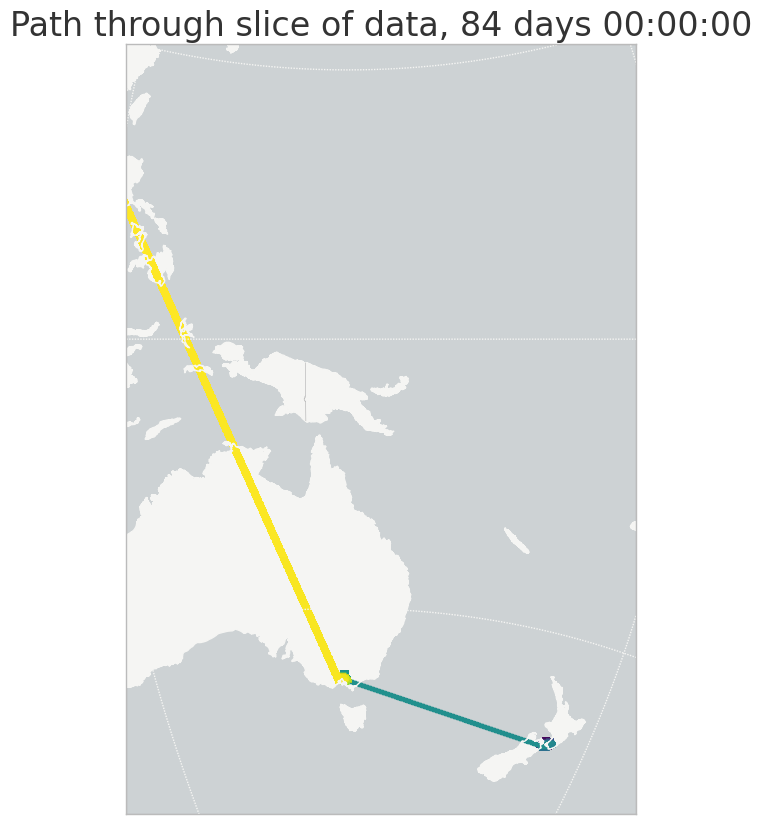

In [383]:
# Note: scatter-plotting the track takes a lot of points, so the slice shouldn't
#   contain more than 1000 points or so (so stride for bigger ranges)
start = 100
end = 300

length = end - start
# length = 10000

max_gps_pts = 100
lat_pad = 5
lon_pad = 5

stride = int(length / max_gps_pts)
df_slice = df_filtered.loc[start:start+length:stride]

pts =df_slice[['lat', 'lon']].to_numpy()
center = get_centermost_point(pts)

date_range = df_slice['datetime'].max() - df_slice['datetime'].min()
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, facecolor='#ffffff', frame_on=False)
ax.set_title('Path through slice of data, {}'.format(
    date_range), fontsize=24, color='#333333')

# Draw the basemap and its features.
m = Basemap(projection='tmerc',
            ellps='WGS84',
            lat_0=center[0],
            lon_0=center[1],
            llcrnrlat=pts[:, 0].min() - lat_pad,
            urcrnrlat=pts[:, 0].max() + lat_pad,
            llcrnrlon=pts[:, 1].min() - lon_pad,
            urcrnrlon=pts[:, 1].max() + lon_pad,
            resolution='h',
            area_thresh=10000)
m.drawmapboundary(color=border_color, fill_color=water_color)
m.drawcoastlines(color=coastline_color)
m.drawcountries(color=border_color)
m.fillcontinents(color=land_color, lake_color=water_color)
m.drawparallels(np.arange(-90., 120., 30.), color=meridian_color)
m.drawmeridians(np.arange(0., 420., 60.), color=meridian_color)

# Project the cluster representative points then scatter plot them.
x, y = m(df_slice['lon'].values, df_slice['lat'].values)

xsamp = np.linspace(x[:-1], x[1:], 1000).T.flatten()
ysamp = np.linspace(y[:-1], y[1:], 1000).T.flatten()
plt.scatter(
    x=xsamp,
    y=ysamp,
    c=np.linspace(-1, 1, xsamp.shape[0]),
    marker='_')

# show the map
plt.savefig('path_of_selected samples.png',
            dpi=96, bbox_inches='tight', pad_inches=0.2)
plt.show()


## Cluster the data!

Number of clusters: 440
Clustered 1600 points down to 440 points, for 72.50% compression in 0.47 seconds.


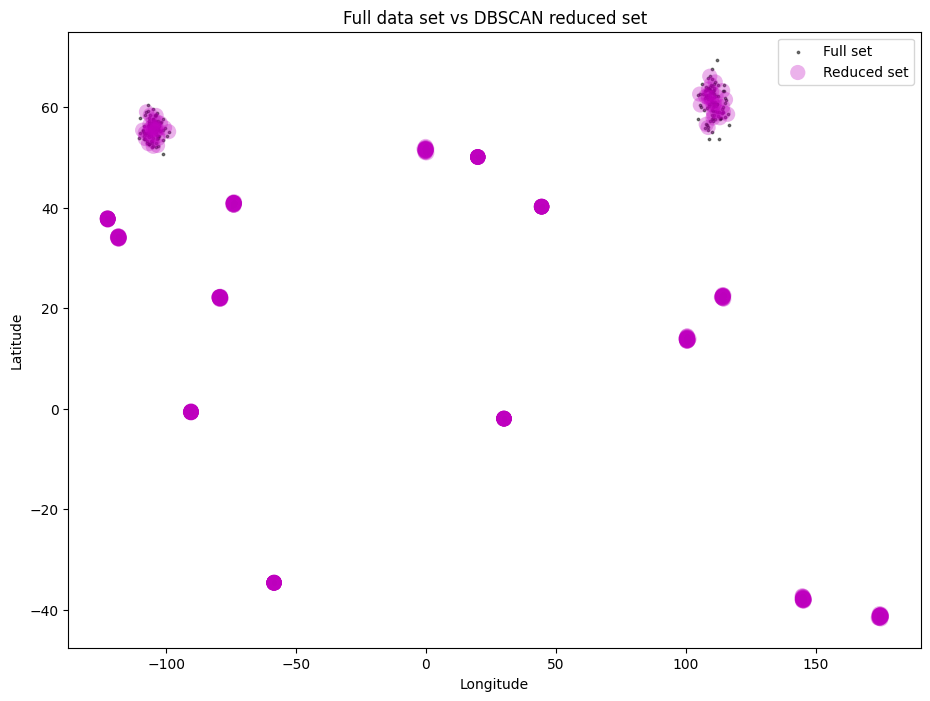

In [384]:
# Uncomment to test on tiny dataset
# num_pts_to_keep = 1500
# mini_df = df_filtered.iloc[0:-1:int(len(df_filtered)/num_pts_to_keep)]
# df_clusters, df_labeled, db = dbscan_reduce(
#     mini_df, cluster_radius=5., min_cluster_size=2, min_samples=1)
# df_clusters

# First cluster the full gps location history data set coarsely, with epsilon=5km in radians.
df_clusters, df_labeled, db = dbscan_reduce(
    df_filtered, cluster_radius=1, min_cluster_size=2, min_samples=1)
df_clusters

# Uncomment to visualize the clustering results:
fig, ax = plt.subplots(figsize=[11, 8])
df_scatter = ax.scatter(
    df_filtered['lon'], df_filtered['lat'], c='k', alpha=0.5, s=3)
rs_scatter = ax.scatter(
    df_clusters['lon'], df_clusters['lat'], c='m', edgecolor='None', alpha=0.3, s=120)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], [
          'Full set', 'Reduced set'], loc='upper right')
plt.show()


## Save/Load Clustering

In [385]:
import pickle

save = False
# save = True

load = False
# load = True

if save:
  with open('cluster_outputs.pkl', 'wb') as f:
    pickle.dump((df_clusters, df_labeled, db), f)
  
if load:
  with open('cluster_outputs.pkl', 'rb') as f:
    df_clusters, df_labeled, db = pickle.load(f)

## Plot clusters on world map
Green points indicate clusters and red points are the original data. Most red
should be covered by green, and any visible red points indicate outliers from
the clustering.

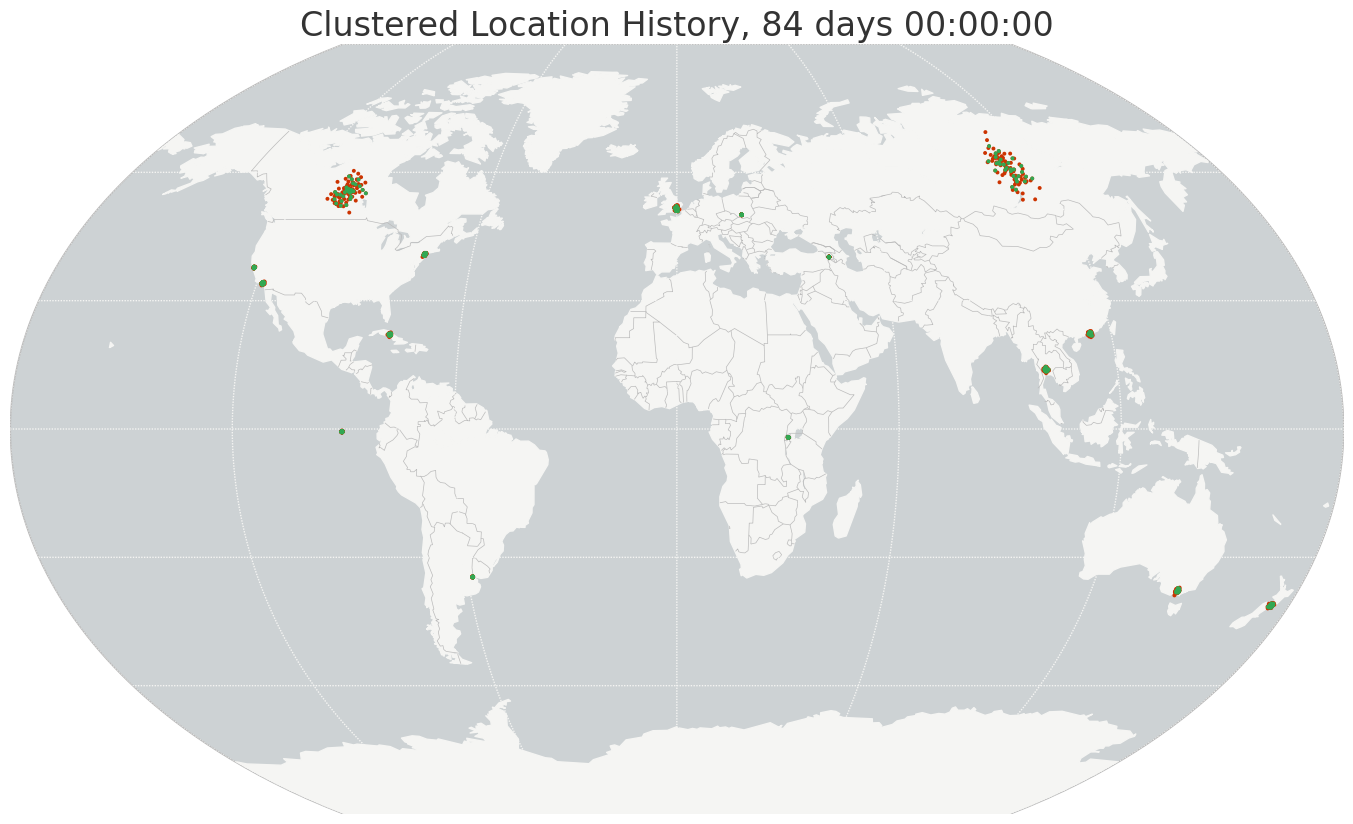

In [386]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, facecolor='#ffffff', frame_on=False)
ax.set_title('Clustered Location History, {}'.format(
    date_range), fontsize=24, color='#333333')

# draw the basemap and its features
m = Basemap(projection='kav7', lon_0=0, resolution='c', area_thresh=10000)
m.drawmapboundary(color=border_color, fill_color=water_color)
m.drawcoastlines(color=coastline_color)
m.drawcountries(color=border_color)
m.fillcontinents(color=land_color, lake_color=water_color)
m.drawparallels(np.arange(-90., 120., 30.), color=meridian_color)
m.drawmeridians(np.arange(0., 420., 60.), color=meridian_color)

# Project the original points then scatter plot them.
x, y = m(df_labeled['lon'].values, df_labeled['lat'].values)
m.scatter(x, y, s=8, color=marker_fill_color,
          edgecolor=marker_edge_color, alpha=1, zorder=3)

# Project the cluster representative points then scatter plot them.
x, y = m(df_clusters['lon'].values, df_clusters['lat'].values)
m.scatter(x, y, s=8, color='#32a852',
          edgecolor=marker_edge_color, alpha=1, zorder=3)

# show the map
plt.savefig('google_location_history_world_map.png',
            dpi=96, bbox_inches='tight', pad_inches=0.2)
plt.show()


# Reverse geo-lookup our clusters

In [387]:
# Note: Failures are typically due to points being outside of country borders,
#   e.g. during flights or offshore boat trips. We ignore for border-crossings.

from geopy.geocoders import Nominatim
from tqdm import tqdm
tqdm.pandas()  # Adds `progress_apply` method to newly created DataFrames

geolocator = Nominatim(user_agent="geoapiExercises")
bad_rows = []

def add_geolookup(row):
  loc = geolocator.reverse(
      f'{str(row.lat)},{str(row.lon)}', language='en', timeout=1)
  address = loc.raw['address']
  return pd.Series([
    loc.raw['address'],
    address.get('city', ''),
    address.get('state', ''),
    address.get('country', ''),
    address.get('country_code'),
    address.get('postcode'),
  ])

def attempt_lookup(row):
  try:
    return add_geolookup(row)
  except:
    global bad_rows
    bad_rows.append(row.copy())
    # print(f'Error on reverse lookup for lat,lon: {row.lat},{row.lon}')

  return pd.Series(np.array([None] * 6))

df_clusters = df_clusters.copy()  # To pick up `progress_apply` method
df_clusters[['address', 'city', 'state', 'country', 'code', 'zipcode']] = (
  df_clusters.progress_apply(attempt_lookup, axis=1)
)

bad_rows = pd.DataFrame(bad_rows)
bad_rows


100%|██████████| 440/440 [03:39<00:00,  2.00it/s]


,index,timestamp,lat,lon,datetime,cluster_label
1,106,2020-02-16 06:00:00,-40.749977,174.496678,2020-02-16 06:00:00,1
35,388,2020-05-13 16:00:00,21.807164,114.632433,2020-05-13 16:00:00,35
102,125,2020-02-17 01:00:00,-41.574172,174.584173,2020-02-17 01:00:00,102
117,133,2020-02-17 09:00:00,-41.603988,174.652371,2020-02-17 09:00:00,117
118,177,2020-02-19 05:00:00,-41.681893,174.702860,2020-02-19 05:00:00,118


## Join country labels with original raw DataFrame.

In [388]:
# Note: the columns we're preserving are from `df_clusters`, which contains the
#   geo-lookup information of the most representative point of the cluster (in
#   the geodesic sense). That means the country and state are probably correct,
#   but the city and address may not be depending on how coarse the clustering
#   was.

cluster_columns_to_keep = ['city', 'state', 'country', 'code', 'zipcode']
df_final = df_labeled.join(
    df_clusters.set_index('cluster_label')[cluster_columns_to_keep],
    on='cluster_label')
df_final

,index,timestamp,lat,lon,datetime,cluster_label,city,state,country,code,zipcode
0,0,2020-01-05 00:00:00,37.848432,-122.394790,2020-01-05 00:00:00,255,San Francisco,California,United States,us,None
1,1,2020-01-05 01:00:00,37.596773,-122.453971,2020-01-05 01:00:00,115,,California,United States,us,94066
2,2,2020-01-05 02:00:00,37.632012,-122.421745,2020-01-05 02:00:00,101,,California,United States,us,94128
3,3,2020-01-05 03:00:00,37.874046,-122.614452,2020-01-05 03:00:00,93,,California,United States,us,None
4,4,2020-01-05 04:00:00,37.684562,-122.323557,2020-01-05 04:00:00,-1,Rukuma,Southern Province,Rwanda,rw,None
...,...,...,...,...,...,...,...,...,...,...,...
1595,1595,2021-09-29 23:00:00,33.944384,-118.475747,2021-09-29 23:00:00,136,Los Angeles,California,United States,us,90293
1596,1596,2021-09-30 00:00:00,33.989765,-118.766449,2021-09-30 00:00:00,201,,California,United States,us,90263
1597,1597,2021-09-30 01:00:00,34.143788,-118.047824,2021-09-30 01:00:00,388,,California,United States,us,91007
1598,1598,2021-09-30 02:00:00,34.022091,-118.136436,2021-09-30 02:00:00,418,,California,United States,us,90022


## Compute Border-Crossings
Lastly we iterate through final clustering and drop contiguous countries, so
we're left with the list of countries we visited, in order.

In [389]:
import pickle
import tqdm

# Ensure the data is sorted by time so we can iterate for border-crossings.
# df_final = df_final.sort_values(by=['timestamp']).reset_index()
# df_final

blacklist_clusters = [-1, 6]

cur = None
border_crossings = []
# for i, row in tqdm(df_final.iterrows()):
for i, row in df_final.iterrows():
  c = row.country
  if c and c != cur and row.cluster_label not in blacklist_clusters:
    cur = c
    border_crossings.append(row)

border_crossings = pd.DataFrame(border_crossings)

columns_to_keep = [
  'lat', 'lon', 'timestamp', 'city', 'state', 'country', 'code', 'zipcode', 'cluster_label']
border_crossings[columns_to_keep].reset_index().to_csv('border_crossings.csv')
border_crossings

,index,timestamp,lat,lon,datetime,cluster_label,city,state,country,code,zipcode
0,0,2020-01-05 00:00:00,37.848432,-122.394790,2020-01-05 00:00:00,255,San Francisco,California,United States,us,None
100,100,2020-02-16 00:00:00,-41.282356,174.739436,2020-02-16 00:00:00,276,Wellington,Wellington,New Zealand,nz,6011
200,200,2020-03-29 00:00:00,-37.830539,144.980961,2020-03-29 00:00:00,421,Melbourne,Victoria,Australia,au,3207
302,302,2020-05-10 02:00:00,22.086674,113.723772,2020-05-10 02:00:00,215,Xiangzhou District,Guangdong Province,China,cn,None
401,401,2020-06-21 01:00:00,13.555128,100.341749,2020-06-21 01:00:00,156,,Samut Sakhon Province,Thailand,th,74000
500,500,2020-08-02 00:00:00,60.298871,110.752634,2020-08-02 00:00:00,407,,Sakha Republic,Russia,ru,None
600,600,2020-09-13 00:00:00,40.179691,44.556649,2020-09-13 00:00:00,160,Yerevan,,Armenia,am,0090
700,700,2020-10-25 00:00:00,50.093159,20.045437,2020-10-25 00:00:00,86,Krakow,Lesser Poland Voivodeship,Poland,pl,31-762
801,801,2020-12-06 01:00:00,51.128462,-0.293306,2020-12-06 01:00:00,303,,England,United Kingdom,gb,RH11 6AT
901,901,2021-01-17 01:00:00,-1.920081,30.124462,2021-01-17 01:00:00,298,,Kigali City,Rwanda,rw,None


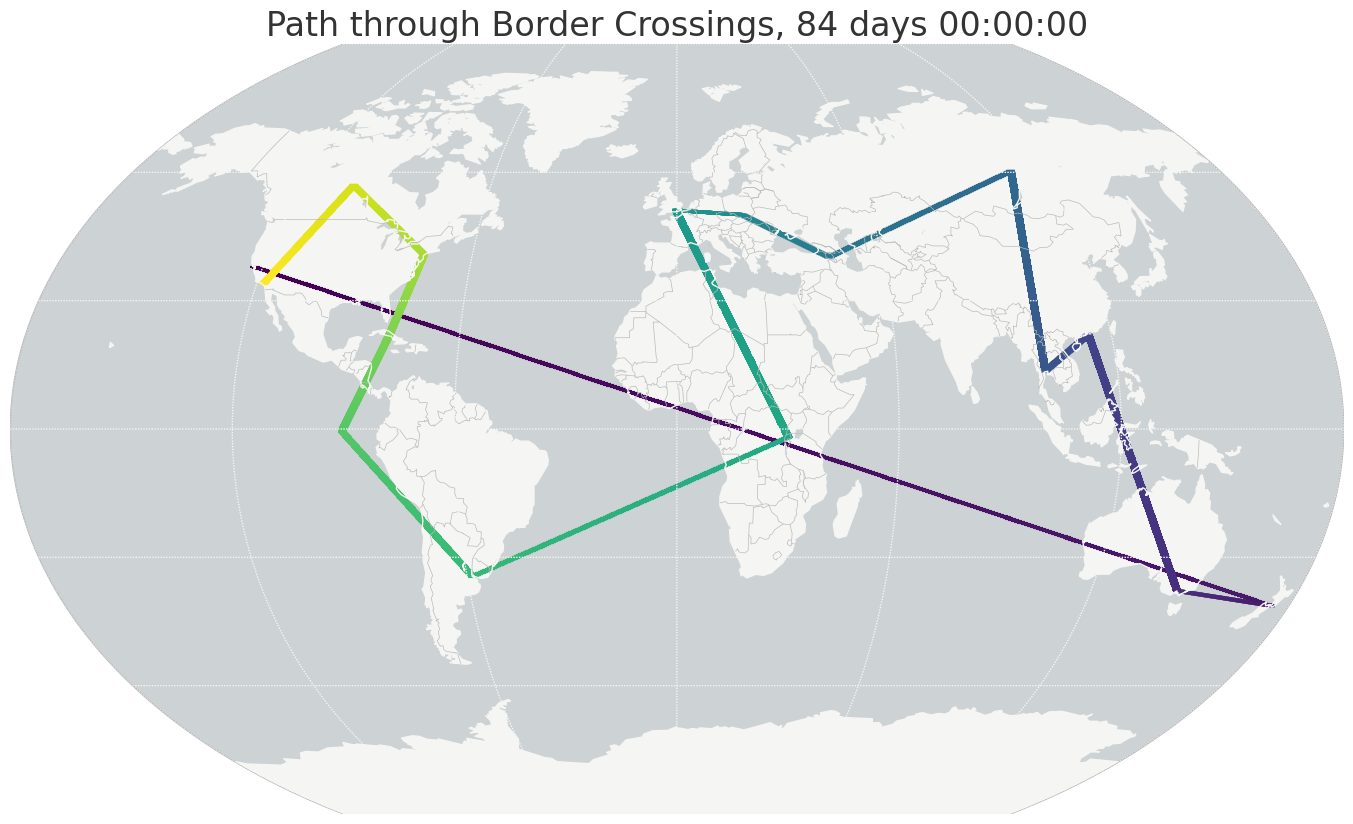

In [390]:
# Plot border crossings

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, facecolor='#ffffff', frame_on=False)
ax.set_title('Path through Border Crossings, {}'.format(
    date_range), fontsize=24, color='#333333')

# draw the basemap and its features
m = Basemap(projection='kav7', lon_0=0, resolution='c', area_thresh=10000)
m.drawmapboundary(color=border_color, fill_color=water_color)
m.drawcoastlines(color=coastline_color)
m.drawcountries(color=border_color)
m.fillcontinents(color=land_color, lake_color=water_color)
m.drawparallels(np.arange(-90., 120., 30.), color=meridian_color)
m.drawmeridians(np.arange(0., 420., 60.), color=meridian_color)

# Project the cluster representative points then scatter plot them.
# m.plot(x, y, c='r')
x, y = m(border_crossings['lon'].values, border_crossings['lat'].values)

xsamp = np.linspace(x[:-1], x[1:], 1000).T.flatten()
ysamp = np.linspace(y[:-1], y[1:], 1000).T.flatten()
plt.scatter(
    x=xsamp,
    y=ysamp,
    c=np.linspace(-1, 1, xsamp.shape[0]),
    marker='_')

# show the map
plt.savefig('google_location_history_world_map.png',
            dpi=96, bbox_inches='tight', pad_inches=0.2)
plt.show()


If using the synthetic dataset, at this point `border_crossings` should have recovered our original clusters-centers. On real dataset you should see your travel history as a single line over time through each country you visited.